In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2018_rahip_brunson/preprocessed_twitter_2018_rahip_brunson.csv')

In [ ]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"gold settles higher recent downdraft, inflatio...",0.283333,0.116667,Positive
1,1,gloves wedding lace ivory bridalgown weddingdr...,0.600000,0.500000,Positive
2,2,boston happening tomorrow _music!! tickets now...,0.602273,-0.306818,Negative
3,3,"第一商品金地金参考価格() : 販売 ,, 買取 ,, 金 gold",0.000000,0.000000,Neutral
4,4,"gold gains percent dollar retreat, short-cover...",0.000000,0.000000,Neutral


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     20822
Positive    17909
Negative     6869
Name: Analysis, dtype: int64
Total comments:  45600


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :48


In [ ]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[806, 9796, 2294, 7553]]


In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [ ]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [ ]:
#train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
#test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

40721    Positive
19071    Negative
8599      Neutral
7131     Positive
16056     Neutral
19079    Negative
28495    Positive
18917     Neutral
11949     Neutral
34109     Neutral
Name: Analysis, dtype: object
Text to number
[2 0 1 2 1 0 2 1 1 1]
Number to category
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005)))     

#model.add(tf.keras.layers.LSTM(64, dropout=0.1, return_sequences=True))
#model.add(tf.keras.layers.Dense(3))

#model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                            kernel_regularizer=regularizers.l2(0.005),\
                                                            bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(3,activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=["CategoricalAccuracy", AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           1920000   
                                                                 
 lstm (LSTM)                 (None, 256, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0

In [ ]:
x_test.shape

(4560, 256)

In [ ]:
test_labels.shape

(4560, 3)

In [ ]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
1283/1283 [==============================] - 1500s 1s/step - loss: 0.8977 - categorical_accuracy: 0.7453 - auc: 0.9002 - val_loss: 0.5066 - val_categorical_accuracy: 0.8702 - val_auc: 0.9739
Epoch 2/10
1283/1283 [==============================] - 1479s 1s/step - loss: 0.4311 - categorical_accuracy: 0.9335 - auc: 0.9857 - val_loss: 0.2605 - val_categorical_accuracy: 0.9875 - val_auc: 0.9979
Epoch 3/10
1283/1283 [==============================] - 1443s 1s/step - loss: 0.3839 - categorical_accuracy: 0.9637 - auc: 0.9938 - val_loss: 0.2188 - val_categorical_accuracy: 0.9914 - val_auc: 0.9986
Epoch 4/10
1283/1283 [==============================] - 1451s 1s/step - loss: 0.5023 - categorical_accuracy: 0.9564 - auc: 0.9929 - val_loss: 0.3406 - val_categorical_accuracy: 0.9803 - val_auc: 0.9976
Epoch 5/10
1283/1283 [==============================] - 1448s 1s/step - loss: 0.2979 - categorical_accuracy: 0.9744 - auc: 0.9957 - val_loss: 0.2058 - val_categorical_accuracy: 0.9934 - val_au

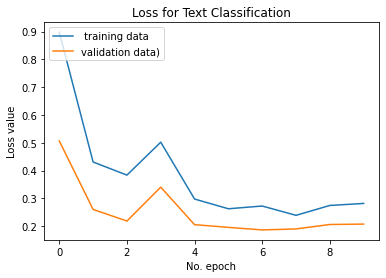

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

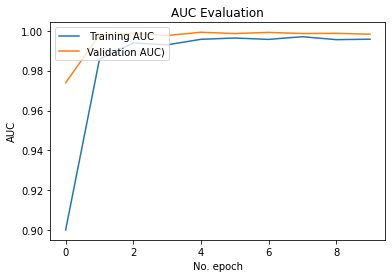

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
X_test

19810    цены на нефть brent $. (+. / +.%) wti $. (+. /...
39208    buy perfect gift paw patrol light sound look-o...
25356    j jesus jewelry jewellery pendant necklace sil...
31266                      turned yellow goldenshower.🤔😆😂🤣
28108    scan results - shooting star candlestick today...
                               ...                        
17833    key differences aware of. lanarealestate buyin...
36956                                  yall damn expensive
42293    antique match safe, metal vesta case, monogram...
18818    bit 'crude' recovery run trading hours: wti $....
44236    happy wednesday! joe live streaming right coas...
Name: tweet, Length: 4560, dtype: object

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-22-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [30]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
143/143 [==============================] - 17s 118ms/step


array([1, 2, 2, ..., 2, 0, 2])

In [27]:
y_test.shape
y_test

19810     Neutral
39208    Positive
25356    Positive
31266     Neutral
28108    Negative
           ...   
17833    Positive
36956    Negative
42293    Positive
18818    Negative
44236    Positive
Name: Analysis, Length: 4560, dtype: object

In [28]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

<ipython-input-28-1433c625cc9b>:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_pred = np.where((y_pred == 0),'Negative',y_pred)


In [29]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00      1782
    Negative       0.98      0.98      0.98       707
     Neutral       0.99      0.99      0.99      2071

    accuracy                           0.99      4560
   macro avg       0.99      0.99      0.99      4560
weighted avg       0.99      0.99      0.99      4560

